# MNIST Digit classification 

Objective is to prepare a convolutional neural network that can achieve about 99.4% validation accuracy with model parameters less than 10K in 15 epochs. We are going to do it in three steps to achieve required goal.



To achieve the goal first we are going to set up a Vanilla  network to start with. Here in this network we will try to get the whole flow right with a proper network setup and we will try to observe result. Now based on result achieved will will try to improve further.

## Necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

!pip install torchsummary
from torchsummary import summary
from torchvision import transforms, datasets, utils

## Prepare dataset

In [ ]:
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [ ]:
train_dataset = datasets.MNIST(root='../data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=test_transform, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
sample = next(iter(train_dataset))
data, label = sample
print(data.shape, type(data))

torch.Size([1, 28, 28]) <class 'torch.Tensor'>


Dataloaders

In [ ]:
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

In [ ]:
sample_images, sample_labels = next(iter(train_loader))
print(sample_images[:16].shape)

torch.Size([16, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 117, 117])


(-0.5, 116.5, 116.5, -0.5)

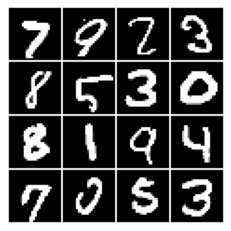

In [ ]:
grid_image = utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## CNN model

In [ ]:
# 4 block model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), bias=True),#26
            nn.ReLU()                      
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), bias=True), #24
            nn.ReLU()                     
        )
        self.transitionblock1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=True), #24
            nn.ReLU()                     
        )

        # Maxpooling
        self.pool1 = nn.MaxPool2d(2, 2) #12


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), bias=True),#10
            nn.ReLU()                      
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),#8
            nn.ReLU()                       
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),#6
            nn.ReLU()                       
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), bias=True),#4
            nn.ReLU()                       
        )

        self.transitionblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, bias=True),#4
            )
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(4, 4), padding=0, bias=False),

        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.transitionblock2(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return x

In [ ]:
use_cuda = torch.cuda.is_available()
# hid_dim =
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             170
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,456
              ReLU-9           [-1, 16, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           2,320
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           2,320
             ReLU-13             [-1, 16, 6, 6]               0
           Conv2

In [ ]:
for batch_id, batch in enumerate(train_loader):
    print(type(batch))
    break

<class 'list'>


## Train and Test

In [ ]:
# Train
# batch = {"data": data, "target": target, "rand_num": rand_num, "sum_of_digits": sum_of_digits}
def train(model, device, train_loader, optimizer, criterion):
    model.train()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_id, batch in enumerate(train_loader):
        data = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        # Gather prediction and calculate loss + backward pass + optimize weights
        label_pred = model(data)
        label_loss = criterion(label_pred, target)
        # Calculate gradients
        label_loss.backward()
        # Optimizer
        optimizer.step()

        # Metrics calculation- For epoch Accuracy(total correct pred/total items) and loss 
        pred = label_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        epoch_loss += label_loss.item()
    
    epoch_accuracy = (100*correct/processed)
    epoch_loss /= len(train_loader)
    print(f"Train set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")

    return epoch_accuracy, epoch_loss

In [ ]:
# Test
def test(model, device, test_loader, criterion):
    model.eval()

    # collect stats - for accuracy calculation
    correct = 0
    processed = 0
    batch_loss = 0
    epoch_loss = 0
    epoch_accuracy = 0

    with torch.no_grad():        
        for batch_id, batch in enumerate(test_loader):
            data = batch[0].to(device)
            target = batch[1].to(device)

            label_pred = model(data)
            label_loss = criterion(label_pred, target)

            # Metrics calculation
            pred = label_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)
            epoch_loss += label_loss.item()
        
    epoch_accuracy = (100*correct)/processed
    epoch_loss /= len(test_loader)
    print(f"Test set: Epoch Accuracy: {round(epoch_accuracy, 2)}  Epoch Loss: {round(epoch_loss, 4)}")
    return epoch_accuracy, epoch_loss

## Model training and Validation

In [ ]:
EPOCHS = 15
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []

# Optimization algorithm from torch.optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Loss condition
criterion = nn.CrossEntropyLoss()

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 84.56  Epoch Loss: 0.4819
Test set: Epoch Accuracy: 94.14  Epoch Loss: 0.1783
Epoch: 1
Train set: Epoch Accuracy: 96.27  Epoch Loss: 0.1229
Test set: Epoch Accuracy: 97.07  Epoch Loss: 0.0872
Epoch: 2
Train set: Epoch Accuracy: 97.05  Epoch Loss: 0.0945
Test set: Epoch Accuracy: 97.71  Epoch Loss: 0.0718
Epoch: 3
Train set: Epoch Accuracy: 97.65  Epoch Loss: 0.075
Test set: Epoch Accuracy: 97.96  Epoch Loss: 0.0656
Epoch: 4
Train set: Epoch Accuracy: 98.01  Epoch Loss: 0.0645
Test set: Epoch Accuracy: 98.33  Epoch Loss: 0.0506
Epoch: 5
Train set: Epoch Accuracy: 98.22  Epoch Loss: 0.0582
Test set: Epoch Accuracy: 98.61  Epoch Loss: 0.0449
Epoch: 6
Train set: Epoch Accuracy: 98.33  Epoch Loss: 0.0531
Test set: Epoch Accuracy: 98.45  Epoch Loss: 0.0496
Epoch: 7
Train set: Epoch Accuracy: 98.46  Epoch Loss: 0.0492
Test set: Epoch Accuracy: 98.32  Epoch Loss: 0.0505
Epoch: 8
Train set: Epoch Accuracy: 98.54  Epoch Loss: 0.0439
Test set: Epoch Accuracy: 9

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

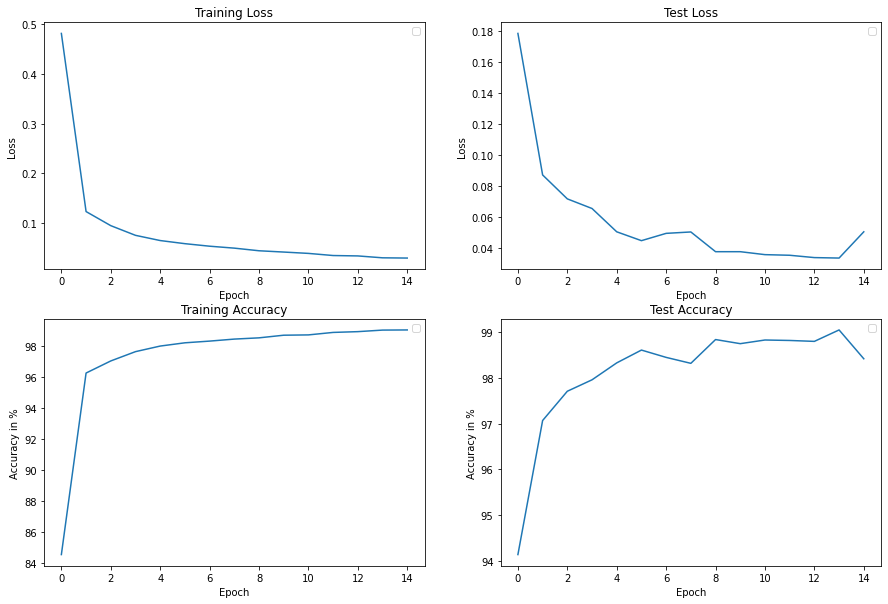

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend(loc="best")

axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy in %")
axs[1, 0].legend(loc="best")

axs[0, 1].plot(test_loss)
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend(loc="best")

axs[1, 1].plot(test_accuracy)
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy in %")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend(loc="best")
plt.figure()